In [1]:
import sys, os
from itertools import chain
from collections import defaultdict, Counter
from IPython.core.interactiveshell import InteractiveShell
from IPython.utils import io
import numpy as np
import pandas as pd

import seaborn as sns
import plotly.express as px
import matplotlib
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV
from sklearn.calibration import CalibratedClassifierCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_absolute_error

from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor

import localization as lx
from utils import split_data_regression, add_coordinates

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

import warnings
warnings.filterwarnings("ignore")
matplotlib.rcParams["figure.figsize"] = (16, 10)

from utils import draw_regression_accuracy

draw_accuracy = lambda model, params: draw_regression_accuracy(df, 40, 300, 400, 8, model, params)

In [2]:
np.random.seed(42)

# Lateration

In [3]:
df = pd.read_csv('../data/fingerprinting_2.csv', index_col='Unnamed: 0')
df = df.reset_index(drop=True)

In [4]:
grouped = df.groupby("Square")

point1 = grouped.get_group("s1").iloc[-100:]
point1["Point"] = 39
point1["Orientation"] = 3.0

point2 = grouped.get_group("s2").iloc[-100:]
point2["Point"] = 39
point2["Orientation"] = 3.0

df = df.append([point1, point2]).reset_index(drop=True)

In [5]:
df = add_coordinates(df)
beacons = ["Server-RSSI-" + str(i) for i in range(1, 6)]
beacons_dist = list(map(lambda x: x+"-distance", beacons))
beacons_location = np.array(
    [
        [0, 420], 
        [0,-20],
        [350,-30],
        [350, 200],
        [350, 425], 
    ])
for b_name, b_loc in zip(beacons, beacons_location):
    df[b_name+"-distance"] = ((df["x"] - b_loc[0])**2 + (df["y"] - b_loc[1])**2)**0.5

In [6]:
df

,Server-RSSI-1,Server-RSSI-2,Server-RSSI-3,Server-RSSI-4,Server-RSSI-5,Square,Point,Orientation,x,y,Server-RSSI-1-distance,Server-RSSI-2-distance,Server-RSSI-3-distance,Server-RSSI-4-distance,Server-RSSI-5-distance
0,-55,-71,-69,-57,-58,s0,0,0.0,20,380,44.721360,400.499688,526.307895,375.898923,333.054050
1,-57,-64,-58,-48,-58,s0,0,0.0,20,380,44.721360,400.499688,526.307895,375.898923,333.054050
2,-57,-64,-58,-48,-58,s0,0,0.0,20,380,44.721360,400.499688,526.307895,375.898923,333.054050
3,-57,-64,-57,-48,-58,s0,0,0.0,20,380,44.721360,400.499688,526.307895,375.898923,333.054050
4,-57,-65,-57,-48,-58,s0,0,0.0,20,380,44.721360,400.499688,526.307895,375.898923,333.054050
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47995,-64,-64,-74,-53,-35,s2,39,3.0,254,350,263.469163,448.793939,391.938771,178.089865,121.823643
47996,-63,-65,-72,-53,-35,s2,39,3.0,254,350,263.469163,448.793939,391.938771,178.089865,121.823643
47997,-63,-65,-72,-54,-35,s2,39,3.0,254,350,263.469163,448.793939,391.938771,178.089865,121.823643
47998,-63,-65,-72,-53,-35,s2,39,3.0,254,350,263.469163,448.793939,391.938771,178.089865,121.823643


In [7]:
import itertools
from utils import get_samples_by_points_num

def split_data_lateration(df, points_num, train_part, validation_part, test_part):
    assert train_part + validation_part + test_part == 1
    division = (np.array(
        points_num*np.array([train_part, validation_part, test_part]))).astype(int)
    assert np.sum(division) == points_num
    for i in range(1, len(division)):
        division[i] += division[i-1]
    division = division[:-1]

    return itertools.chain.from_iterable(
        map(lambda data: (data[beacons], data[list(map(lambda x: x+"-distance", beacons)) + ["x", "y"]]),
            map(lambda points: get_samples_by_points_num(df, points),
                np.split(np.random.permutation(np.arange(points_num)), division))))


In [8]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data_lateration(
    df, points_num=40, train_part=0.7, validation_part=0.15, test_part=0.15)

# One regressor to rule them all

## Visualize data

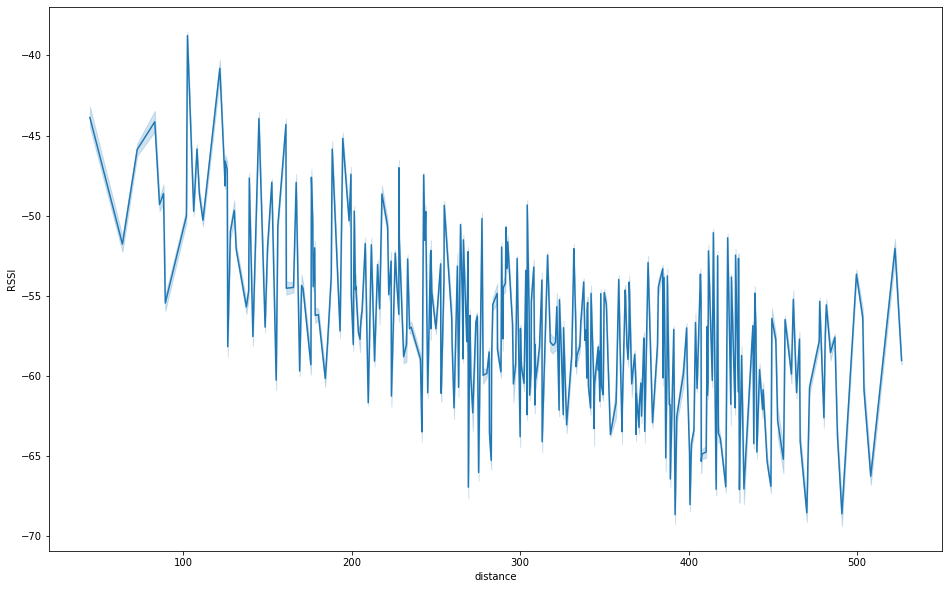

In [9]:
df_merged = pd.DataFrame({"RSSI": pd.concat( [df[b] for b in beacons]), 
                          "distance": pd.concat([df[b] for b in beacons_dist])})
sns.lineplot(x=df_merged["distance"], y=df_merged["RSSI"])

## Regression for predicting distances

Mean absolute error for RandomForest: 79.84424758908013
Mean absolute error for XGB: 79.84811266462033
Mean absolute error for Linear Regression: 81.43002001952408


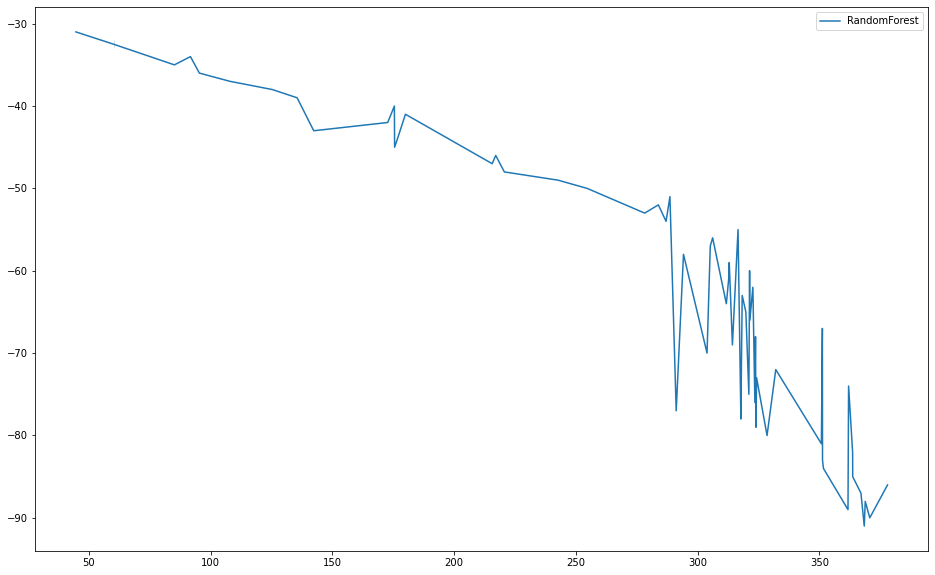

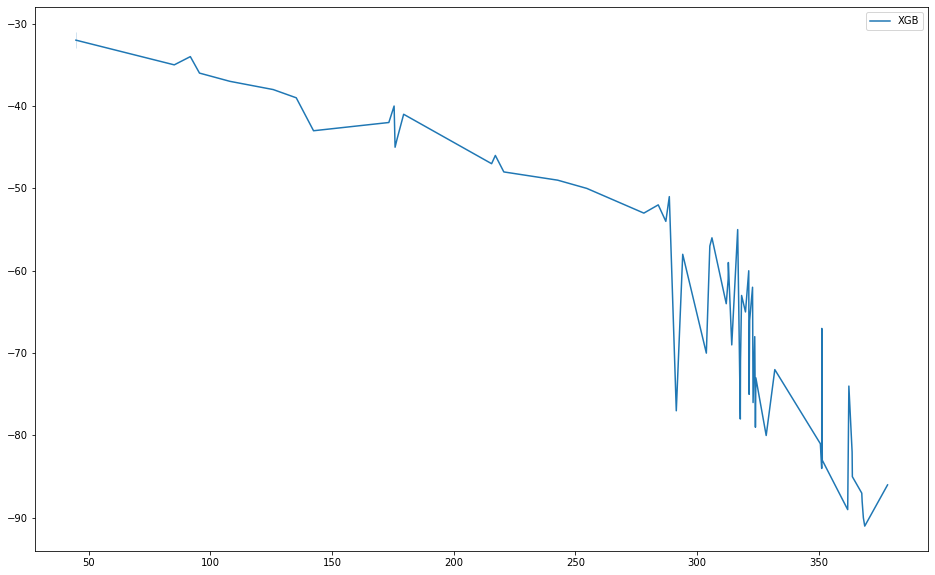

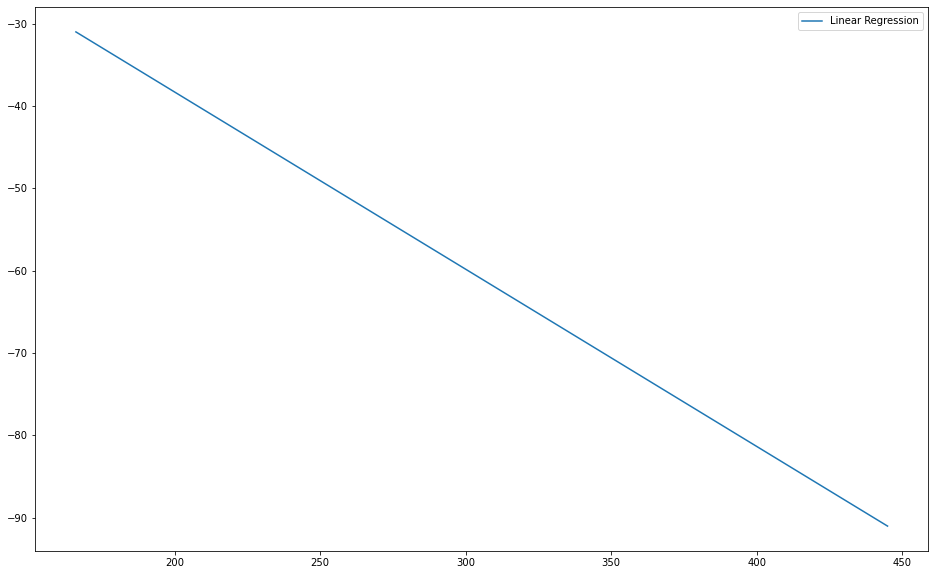

In [10]:
X_train_all = pd.concat([X_train[b] for b in beacons]).values.reshape(-1,1)
y_train_all = pd.concat([y_train[b] for b in map(lambda x: x+"-distance", beacons)]).values

for model, name in zip([RandomForestRegressor(), XGBRegressor(), LinearRegression()], ["RandomForest", "XGB", "Linear Regression"]):
    model.fit(X_train_all, y_train_all)
    predicted = model.predict(pd.concat([X_val[b] for b in beacons]).values.reshape(-1,1))
    err = mean_absolute_error(pd.concat([y_val[b] for b in beacons_dist]), predicted)
    print(f"Mean absolute error for {name}: {err}")

    rssi = np.arange(X_train_all.min(), X_train_all.max(), 1)
    dist = model.predict(rssi.reshape(-1, 1))

    fig = plt.figure()
    line = sns.lineplot(x=dist, y=rssi)
    legend = plt.legend([name])

## Multilateration

In [11]:
def predict_coordinates(distances):
    P = lx.Project("2D", "LSE")
    for name, p in zip(beacons, beacons_location):
        P.add_anchor(name, tuple(p))
    targets = []
    for i in range(distances.shape[0]):
        target, label = P.add_target()

        for b_num, name in enumerate(beacons):
            target.add_measure(name, distances[i][b_num])
        targets.append(target)
    # Surpress prints
#     sys.stdout = open(os.devnull, 'w')
    with io.capture_output() as captured:
        P.solve()
    # Restore prints
#     sys.stdout = sys.__stdout__
    return np.array([np.array([t.loc.x, t.loc.y]) for t in targets])

In [48]:
def evaluate_model(test, predicted):
    return np.mean(np.apply_along_axis(lambda x: np.sqrt(np.sum(np.square(x))), 1, np.abs(predicted - test[["x", "y"]].values)))

In [ ]:
for model, name in zip([RandomForestRegressor(), XGBRegressor(), LinearRegression()], ["RandomForest", "XGB", "Linear Regression"]):
    model.fit(X_train_all, y_train_all);

    distances = np.array([model.predict(X_val[[b]].values) for b in beacons]).T
    print(name, "has accuracy:", evaluate_model(y_val, predict_coordinates(distances)))

RandomForest has accuracy: 117.25033090393634


# One regressor per each beacon

## Visualize data

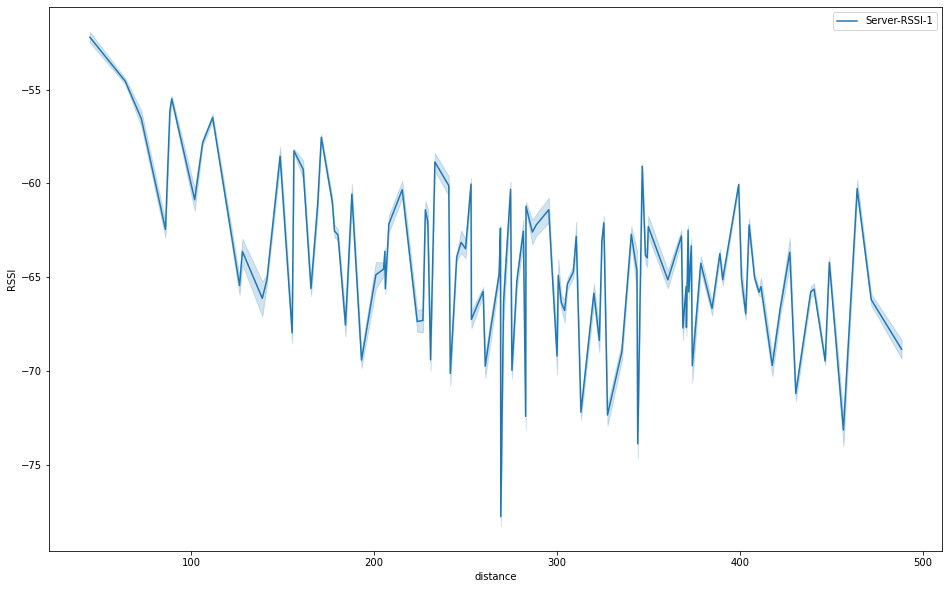

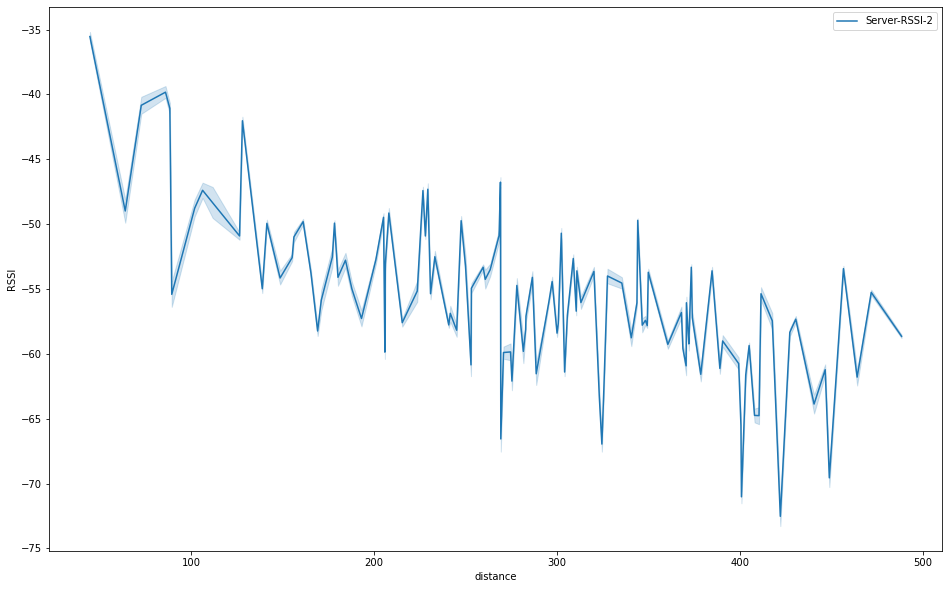

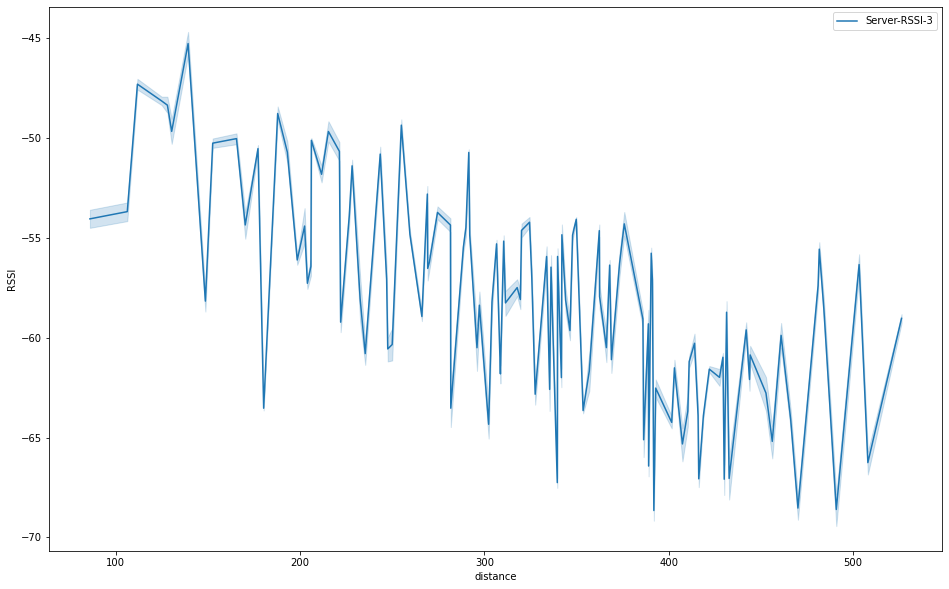

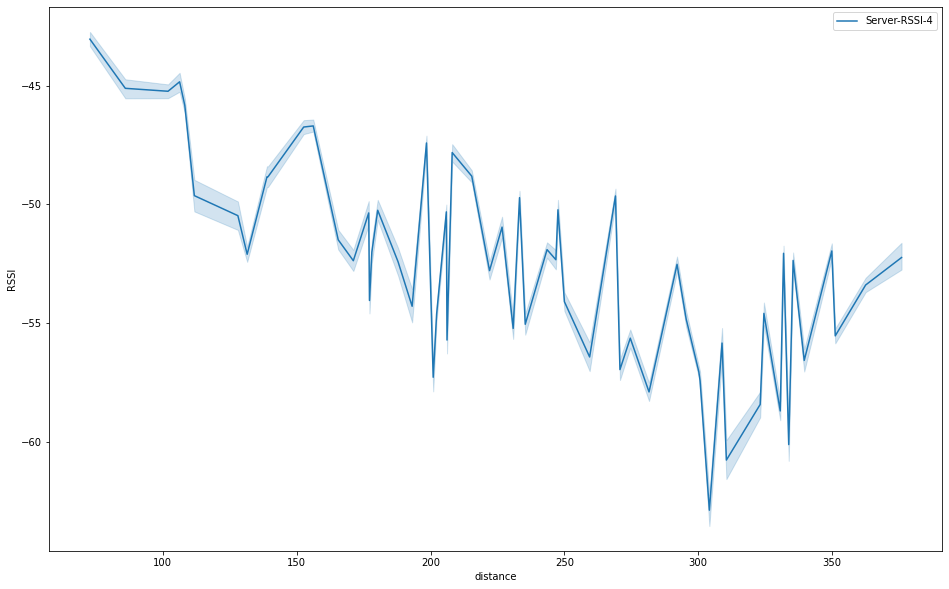

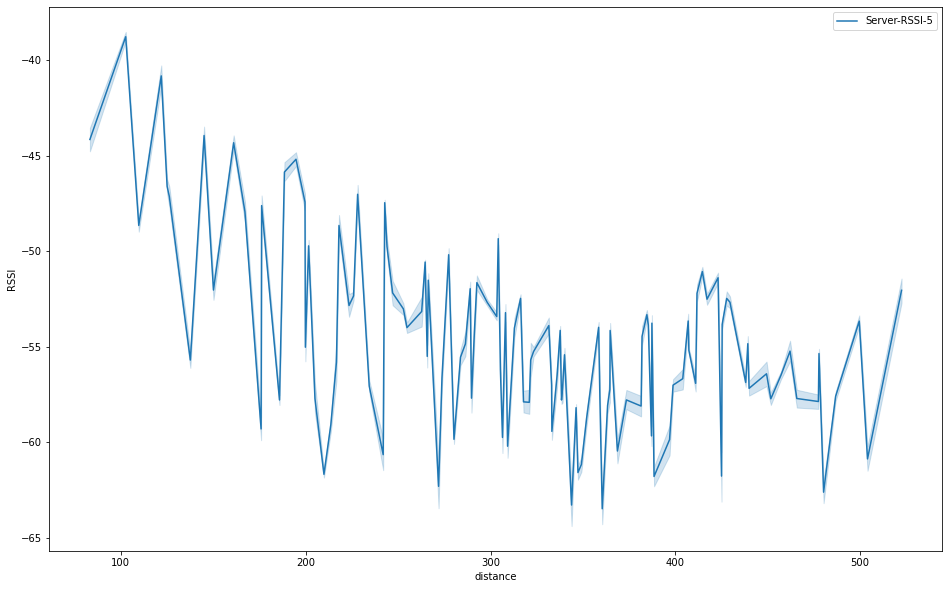

In [18]:
for name, dist in zip(beacons, beacons_dist):
    df_per_beacon = pd.DataFrame({"RSSI": df[name], 
                                  "distance": df[dist]})
    fig = plt.figure()
    line = sns.lineplot(x=df_per_beacon["distance"], y=df_per_beacon["RSSI"])
    legend = plt.legend([name])

## Regression for distance predicting

In [33]:
def get_per_beacon_models(model, params):
    models = []
    for b_name, param in zip(beacons, params):
        models.append(model(**param))
        models[-1].fit(X_train[[b_name]].values, y_train[b_name+"-distance"].values)
    return models
        
def evaluate_distance_models(models):
    accs = []
    for i, beacon in enumerate(beacons):
        predicted = models[i].predict(X_val[[beacon]].values)
        acc = mean_absolute_error(y_val[beacon+"-distance"], predicted)
        print("Mean absolute error for {} beacon: {:2}".format(i+1, acc))
        accs.append(acc)
    print("Mean absolute error: {:2}".format(np.mean(np.array(accs))))

In [20]:
# minimizing distance
def model_accuracy(params,model,train_data,train_labels,cv_data,cv_labels):
    model = model(**params)
    model.fit(train_data, train_labels)
    preds = model.predict(cv_data)
    return {'loss': mean_absolute_error(cv_labels, preds), 'status': STATUS_OK}

### XGBRegressor

In [21]:
%%script false --no-raise-error
models_best_params_xgb = []
for i in beacons:
    max_depth = np.arange(3, 20, dtype=int)
    sampling_method = ['gradient_based', 'uniform']
    xgb_fspace = {
        'eta':hp.uniform('eta', 0.01, 1),
        'gamma':hp.uniform('gamma', 0.01, 1),
        'max_depth':hp.choice('max_depth', max_depth),
        'min_child_weight': hp.uniform('min_child_weight', 0, 1),
        'subsample': hp.uniform('subsample', 0, 1), 
        'sampling_method': hp.choice('sampling_method',sampling_method)
    }

    xgb_accuracy = lambda x:model_accuracy(x,model=XGBRegressor,train_data=X_train[[i]],train_labels=y_train[i+"-distance"],cv_data=X_val[[i]],cv_labels=y_val[[i+"-distance"]])
    trials = Trials()
    best_xgb = fmin(
        fn=xgb_accuracy,
        space=xgb_fspace,
        algo=tpe.suggest,
        max_evals=50, trials=trials, rstate=np.random.RandomState(0))
    best_xgb['sampling_method']=sampling_method[best_xgb['sampling_method']]
    best_xgb['max_depth']=max_depth[best_xgb['max_depth']]
    print('Best parameters: ')
    for param in best_xgb:
        print(param, best_xgb[param])
    models_best_params_xgb.append(best_xgb)

In [22]:
models_best_params_xgb =  [
 {'eta': 0.4990722208936885,
  'gamma': 0.7754177373732427,
  'max_depth': 14,
  'min_child_weight': 0.613334425428097,
  'sampling_method': 'uniform',
  'subsample': 0.02256880270358344},
 {'eta': 0.7188212245340684,
  'gamma': 0.7115346872920516,
  'max_depth': 11,
  'min_child_weight': 0.8619980301165149,
  'sampling_method': 'gradient_based',
  'subsample': 0.02241063973189128},
 {'eta': 0.995305737149512,
  'gamma': 0.8659127197064723,
  'max_depth': 9,
  'min_child_weight': 0.8160289898763478,
  'sampling_method': 'gradient_based',
  'subsample': 0.06659140087046334},
 {'eta': 0.11527594761695514,
  'gamma': 0.7249168412963541,
  'max_depth': 4,
  'min_child_weight': 0.8574846485149644,
  'sampling_method': 'uniform',
  'subsample': 0.616830281088266},
 {'eta': 0.16309994675899536,
  'gamma': 0.9952796405334583,
  'max_depth': 3,
  'min_child_weight': 0.35390483477863127,
  'sampling_method': 'uniform',
  'subsample': 0.2293950898824746}]

In [23]:
models_xgb = get_per_beacon_models(XGBRegressor, models_best_params_xgb)
evaluate_distance_models(models_xgb)

Mean absolute error for 1 beacon: 93.13014730455001
Mean absolute error for 2 beacon: 80.59650381411112
Mean absolute error for 3 beacon: 77.04306789161794
Mean absolute error for 4 beacon: 61.170600648696016
Mean absolute error for 5 beacon: 76.65838443793069
Mean absolute error: 77.71974081938114


### RandomForestRegressor

In [24]:
%%script false --no-raise-error
models_best_params_rf = []
for i in beacons:
    max_depth = np.arange(3, 20, dtype=int)
#     max_features=np.arange(1,2,dtype=int)
    n_estimators=np.arange(100,201,50)
    rf_fspace = {
        'max_depth':hp.choice('max_depth', max_depth),
#         'max_features': hp.choice('max_features', max_features),
        'n_estimators': hp.choice('n_estimators',n_estimators )
    }

    rf_accuracy = lambda x:model_accuracy(x,model=RandomForestRegressor,train_data=X_train[[i]],train_labels=y_train[i+"-distance"],cv_data=X_val[[i]],cv_labels=y_val[[i+"-distance"]])
    trials = Trials()
    best_rf = fmin(
        fn=rf_accuracy,
        space=rf_fspace,
        algo=tpe.suggest,
        max_evals=50, trials=trials, rstate=np.random.RandomState(0))
#     best_rf['max_features']=max_features[best_rf['max_features']]
    best_rf['n_estimators']=n_estimators[best_rf['n_estimators']]
    best_rf['max_depth']=max_depth[best_rf['max_depth']]
    print('Best parameters: ')
    for param in best_rf:
        print(param, best_rf[param])
    models_best_params_rf.append(best_rf)

In [25]:
models_best_params_rf = [
 {'max_depth': 3, 'n_estimators': 150},
 {'max_depth': 8, 'n_estimators': 100},
 {'max_depth': 16, 'n_estimators': 100},
 {'max_depth': 4, 'n_estimators': 200},
 {'max_depth': 5, 'n_estimators': 200}]

In [26]:
models_rf = get_per_beacon_models(RandomForestRegressor, models_best_params_rf)
evaluate_distance_models(models_rf)

Mean absolute error for 1 beacon: 87.20888465715338
Mean absolute error for 2 beacon: 80.89113637066536
Mean absolute error for 3 beacon: 77.4899732303144
Mean absolute error for 4 beacon: 59.93610820107791
Mean absolute error for 5 beacon: 76.43123430975629
Mean absolute error: 76.39146735379347


### Linear Regression

In [27]:
models_lin = get_per_beacon_models(LinearRegression, [{}]*5)
evaluate_distance_models(models_lin)

Mean absolute error for 1 beacon: 89.7583819910306
Mean absolute error for 2 beacon: 76.3503980227782
Mean absolute error for 3 beacon: 77.74315187517345
Mean absolute error for 4 beacon: 59.26870197057377
Mean absolute error for 5 beacon: 79.17990161781131
Mean absolute error: 76.46010709547348


### Support Vector Machine

In [28]:
%%script false --no-raise-error
models_svr = get_per_beacon_models(SVR, [{"kernel": "poly", "degree": 3}]*5)
evaluate_models(models_svr)

In [29]:
models_svr = []

In [30]:
df[beacons].describe()

,Server-RSSI-1,Server-RSSI-2,Server-RSSI-3,Server-RSSI-4,Server-RSSI-5
count,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000
mean,-64.412937,-55.805479,-57.938042,-52.637292,-54.646813
std,6.644848,8.006210,7.469752,7.724370,7.069871
min,-91.000000,-91.000000,-90.000000,-91.000000,-90.000000
25%,-68.000000,-60.000000,-63.000000,-57.000000,-59.000000
50%,-64.000000,-56.000000,-57.000000,-51.000000,-54.000000
75%,-60.000000,-51.000000,-53.000000,-48.000000,-50.000000
max,-48.000000,-30.000000,-36.000000,-34.000000,-34.000000


In [31]:
df[beacons_dist].describe()

,Server-RSSI-1-distance,Server-RSSI-2-distance,Server-RSSI-3-distance,Server-RSSI-4-distance,Server-RSSI-5-distance
count,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000
mean,283.721301,283.721301,320.460152,232.292475,316.998934
std,103.782053,103.782053,101.458230,78.285378,101.119512
min,44.721360,44.721360,86.023253,72.801099,83.216585
25%,206.094612,206.094612,247.436721,177.129854,243.669274
50%,287.574185,287.574185,326.648368,232.053002,322.528137
75%,370.579270,370.579270,395.108669,300.311435,390.591550
max,488.262225,488.262225,526.307895,375.898923,522.422243


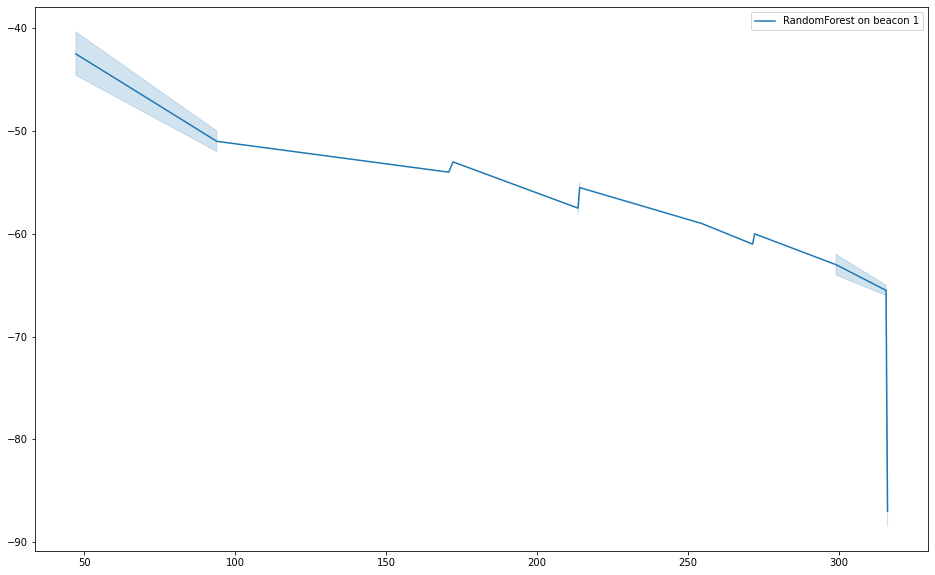

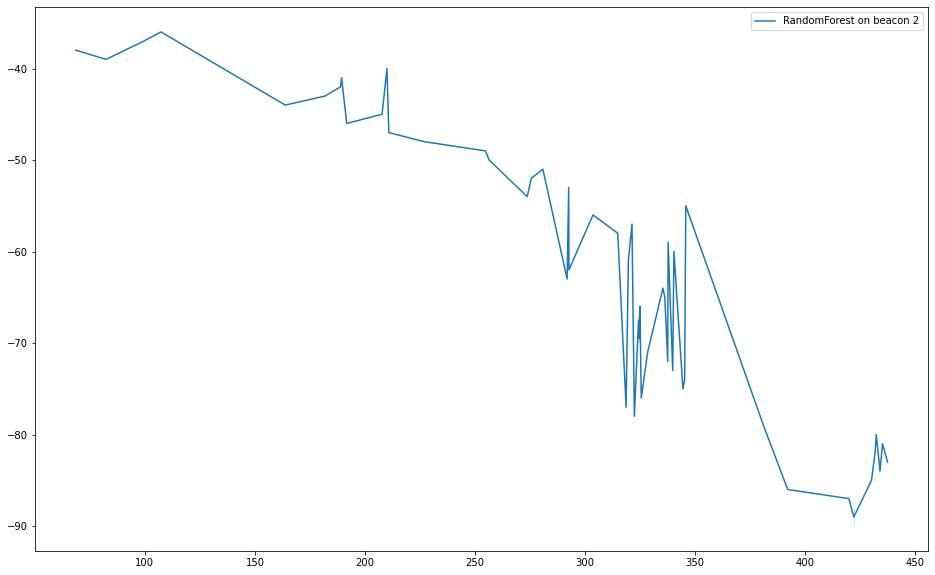

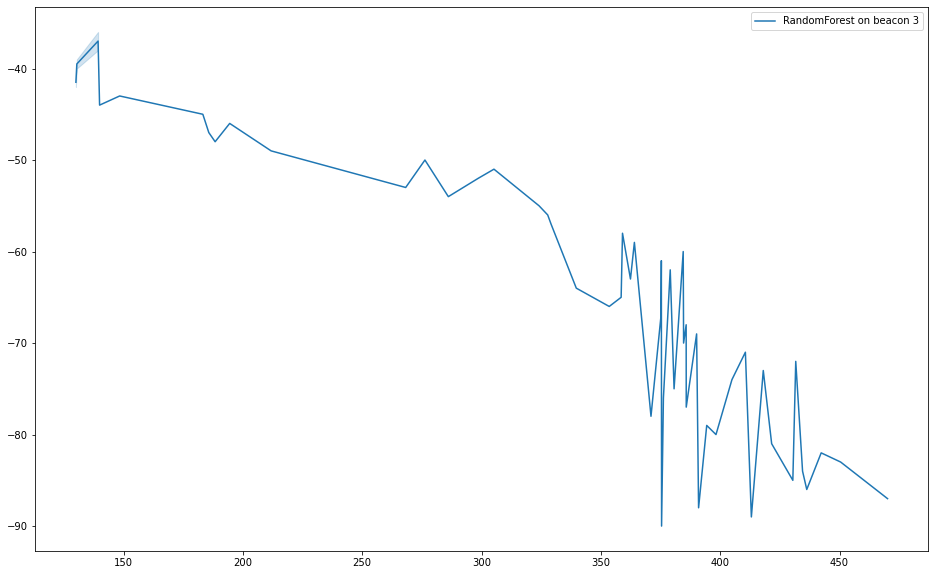

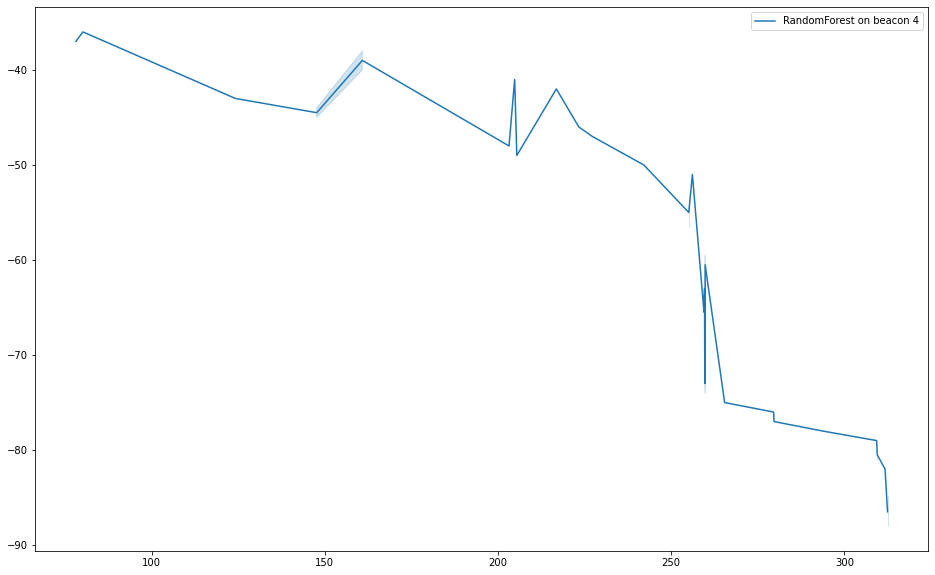

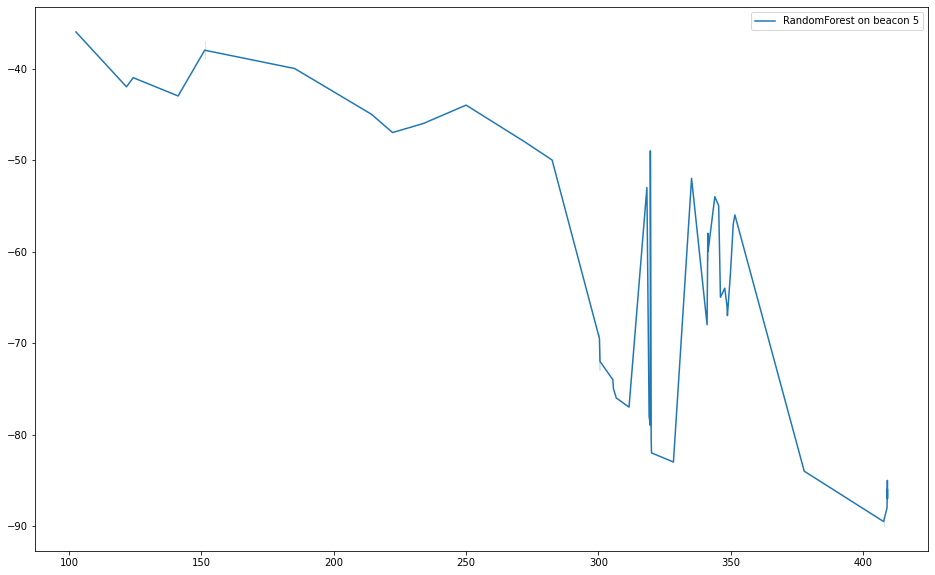

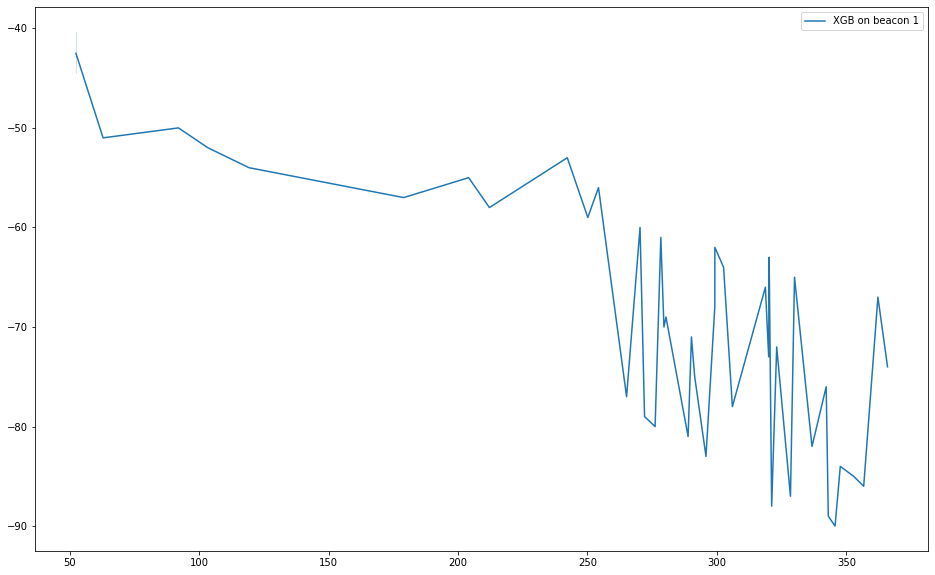

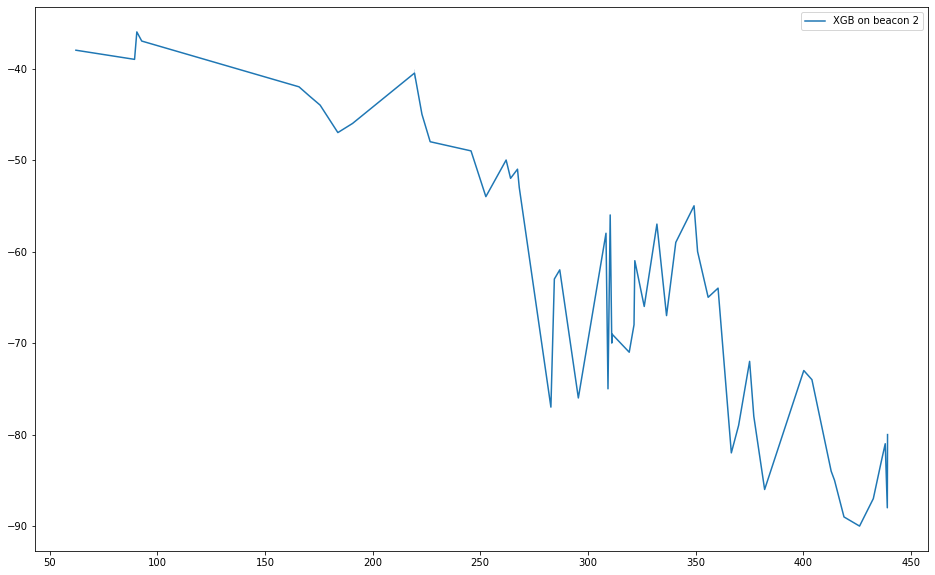

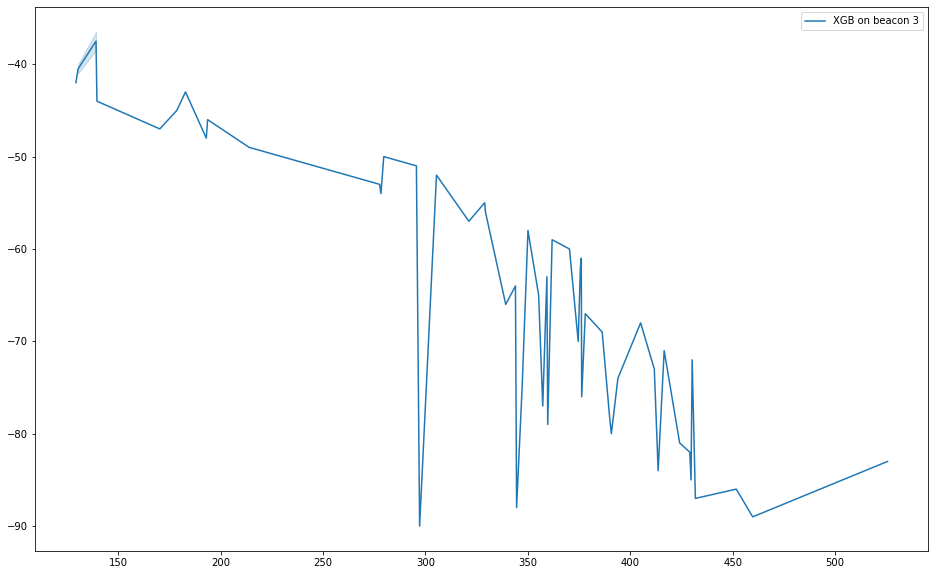

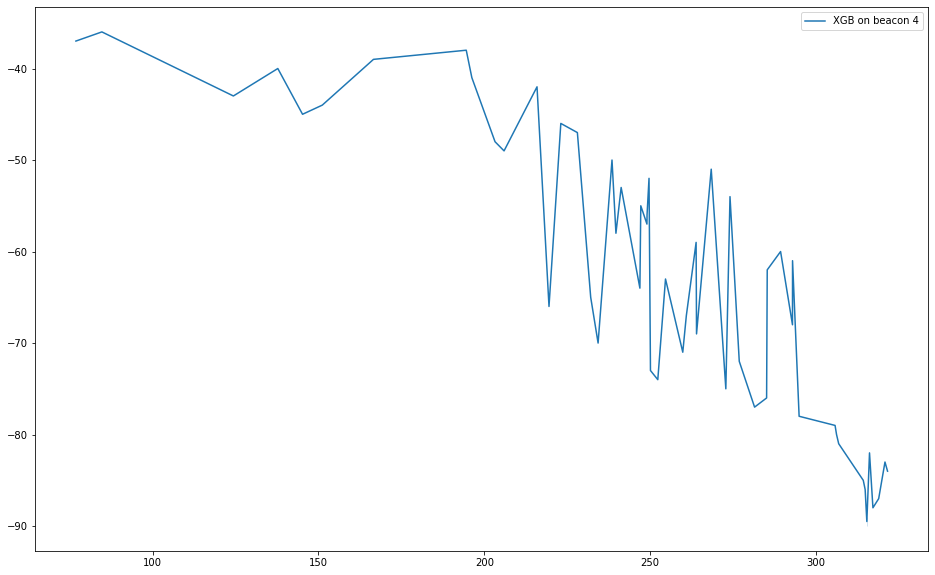

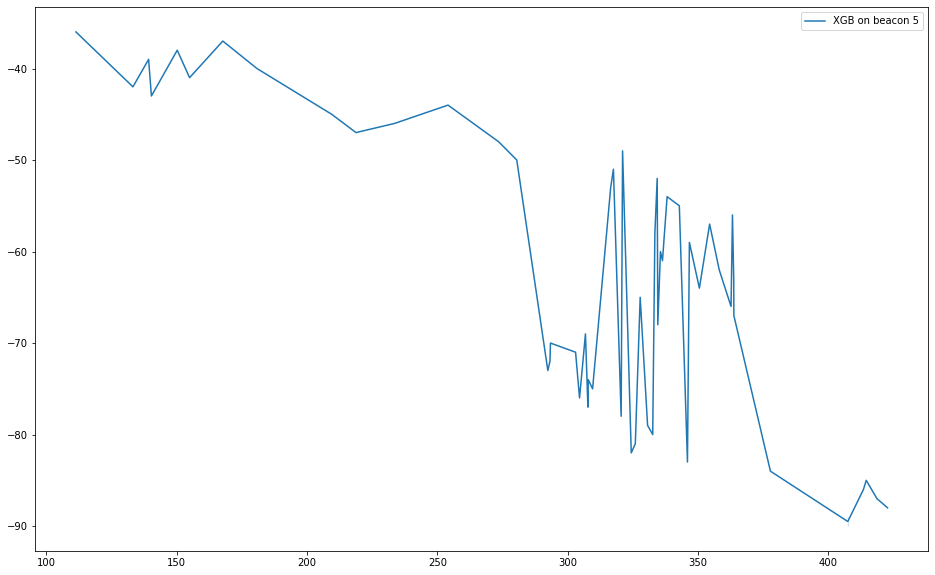

In [32]:
for models, name in zip([models_rf, models_xgb, models_svr], ["RandomForest", "XGB", "SVM"]):
    rssi = np.arange(-90, -35, 1)
    dists = []
    for model in models:
        dists.append(model.predict(rssi.reshape(-1, 1)))

    for b_num, dist in enumerate(dists):
        fig = plt.figure()
        line = sns.lineplot(x=dist, y=rssi)
        legend = plt.legend([name + " on beacon " + str(b_num + 1)])

## Multilateration

In [45]:
for models, name in zip([models_rf, models_xgb, models_lin], ["RandomForest", "XGB", "Linear Regression"]):
    cols = []
    for i, b_name in enumerate(beacons):
        cols.append(models[i].predict(X_val[[b_name]].values))
    distances = np.array(cols).T
    print(name, "has accuracy:", evaluate_model(y_val, predict_coordinates(distances)))

RandomForest has accuracy: 116.08762957559982
XGB has accuracy: 117.43329797407131
Linear Regression has accuracy: 120.12248811702565
